In [123]:
import numpy as np
import torch
import sys
import scipy as scp
from functools import reduce
from itertools import product, permutations
import qiskit as qis
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

np.set_printoptions(edgeitems=300, threshold=20000, linewidth=150)
torch.set_printoptions(edgeitems=300, threshold=20000, linewidth=150)

print("Python version:", sys.version)
print("Pytorch version:", torch.__version__)
print("NumPy version:", np.__version__)
print("SciPy version:", scp.__version__)
print("Matplotlib version:", mpl.__version__)
print("Seaborn version:", sns.__version__)
print("Qiskit version:", qis.__version__)

Python version: 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)]
Pytorch version: 2.3.1
NumPy version: 1.26.4
SciPy version: 1.14.1
Matplotlib version: 3.9.2
Seaborn version: 0.13.1
Qiskit version: 1.1.0


In [124]:
def N_CZ_gates(graph, N):
    """
    Construct ring of CZ gates for N > 1 qubits.
    """
    cz = torch.tensor([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, -1]], dtype=torch.float64)
    val = []
    if N < 2:
        raise ValueError("Number of qubits must be at least 2")
    elif N == 2:
        return cz
    else:
        for i in range(len(graph)-1):
            cz_i = cz
            for j in range(N):
                if np.all(graph[i] > j):
                    cz_i = torch.kron(torch.eye(2), cz_i)
                elif np.all(graph[i] < j):
                    cz_i = torch.kron(cz_i, torch.eye(2))
                
            val.append(cz_i)

        val.append(torch.kron(torch.tensor([[1, 0], [0, 0]]), torch.eye(2**(N-1))) + torch.kron(torch.kron(torch.tensor([[0, 0], [0, 1]]), torch.eye(2**(N-2))), torch.tensor([[1, 0], [0, -1]])))
        val[-1] = val[-1].to(torch.float64)

        return reduce(torch.matmul, val)


def fidelity(den, den1):
    """
    Calculates the fidelity between state den and den1.
    """
    sqrt_den = scp.linalg.sqrtm(den)
    fid_eig = scp.linalg.eigvals(np.einsum('ij,jk,kl -> il', sqrt_den, den1, sqrt_den))

    fidelity = np.real((fid_eig[fid_eig > 0]**0.5).sum())**2
    
    return fidelity


def custom_loss(x, y):
    """
    Loss function implementing the scaled Hilbert-Schmidt norm squared.
    """
    df = x-y
    ld_re = torch.real(df)
    ld_im = torch.imag(df)

    return (ld_re**2+ld_im**2).sum()/ld_re.size()[0]


In [172]:
class ParameterizedOperator(torch.nn.Module):
    """
    The relativistic variational quantum circuit model.
    """
    def __init__(self, num_params, coupling, dt, smear, seed, Pauli_dir, dist, p, iden):
        super(ParameterizedOperator, self).__init__()
        self.rng = np.random.default_rng(seed)
        self.num_UDW = num_params[0]
        self.coupling = torch.tensor(coupling)
        self.dt = torch.tensor(dt)
        self.smear = torch.tensor(smear)
        self.Pauli_dir = Pauli_dir
        self.dx = [self.coupling**2*self.dt*torch.norm(dist.unsqueeze(1)-dist.unsqueeze(0), dim=-1) for a in range(len(num_params))] # Construct the UDW distance matrix
        self.tpi = torch.tensor(np.pi)
        
        # Trainable rotation angles
        self.params = [torch.tensor(np.pi*self.rng.uniform(0, 10, size=num_params[i]), requires_grad=True) for i in range(len(num_params))] # make sure this adheres to lambda^2 << params
        # Trainable angles for normal vector in rotation operators
        self.nrot1 = [torch.tensor(2*np.pi*self.rng.uniform(0, 1, size=num_params[i]), requires_grad=True) for i in range(len(num_params))]
        self.nrot2 = [torch.tensor(2*np.pi*self.rng.uniform(0, 1, size=num_params[i]), requires_grad=True) for i in range(len(num_params))]
        
        # The symmetric propagator for each layer (the coefficients appearing in the entangling gates)
        self.sym_prop = [torch.nan_to_num(-self.dt/(2*torch.sqrt(self.tpi)*torch.sqrt(1+self.smear**2/self.dt**2)*self.dx[i])
                         *torch.exp(-self.dx[i]**2/(4*(self.dt**2+self.smear**2)))*torch.erf(self.dx[i]/(2*self.smear*torch.sqrt(1+self.smear**2/self.dt**2))), nan=-self.dt/(2*self.tpi*self.smear*(1+self.smear**2/self.dt**2))) for i in range(len(num_params))]
        # The Wightman function for each layer (only used for the EPhiChannel function)
        self.wightman = [torch.nan_to_num(self.dt/(4*torch.sqrt(self.tpi)*torch.sqrt(1+self.smear**2/self.dt**2)*self.dx[i])
                         *torch.exp(-self.dx[i]**2/(4*(self.dt**2+self.smear**2)))*torch.tensor(scp.special.erfi(self.dx[i].numpy()/(2*torch.sqrt(self.dt**2+self.smear**2).numpy()))), nan=1/(4*self.tpi*(1+self.smear**2/self.dt**2))).to(torch.complex128) for i in range(len(num_params))]

        # The entangling gate for each layer
        self.EntOp_list = torch.linalg.matrix_exp(torch.stack([-1j*(self.coupling**2/2)*self.Hamiltonian_NL(D-1-i, p, iden) for i in range(D)]))

        # Note that if one wishes to also train the coefficients in the entangling gate or EPhiChannel, then the above 3 lists must be moved into the forward method below
    
    def forward(self, den, D, calc_type, p, iden):
        """
        Application of the RVQC channel for D layers to the input state den.
        """
        RotOp_list = torch.linalg.matrix_exp(torch.stack([-1j*sum([self.params[D-1-i][j]*self.NPauliOperators(D-1-i, 0, [j], p, iden) for j in range(len(self.params[D-1-i]))]) for i in range(D)]))

        if calc_type == "Unitary":
            return reduce(torch.matmul, torch.bmm(self.EntOp_list, RotOp_list))
        elif calc_type == "Channel":
            U_list = torch.bmm(self.EntOp_list, RotOp_list)
            U_list_dag = U_list.adjoint()
            den_f = den
            for d in range(D):
                den_f = self.EPhiChannel(den_f, d)
                den_f = torch.matmul(U_list[d], torch.matmul(den_f, U_list_dag[d]))

            return den_f

    
    def Hamiltonian_NL(self, d, p, iden):
        """
        Interaction Hamiltonian for field-mediated entangling operator.
        """
        return sum([sum([self.sym_prop[d][i, j]*self.NPauliOperators(d, 1, [i, j], p, iden) for j in range(i+1, len(self.dx[d]))]) for i in range(len(self.dx[d]))])


    def Hamiltonian_L(self, d, p, iden):
        """
        Free Hamiltonian for local rotation operators.
        """
        return sum([self.params[d][i]*self.NPauliOperators(d, 0, [i], p, iden) for i in range(len(self.params[d]))])

    
    def NPauliOperators(self, d, d1, n, p, iden):
        """
        Construct Pauli operators for N qubits.
        """
        if d1 == 0:
            nrot_tot = [torch.sin(self.nrot1[d])*torch.cos(self.nrot2[d]), torch.sin(self.nrot1[d])*torch.sin(self.nrot2[d]), torch.cos(self.nrot1[d])]
            rot_mat = torch.stack([sum([nrot_tot[j][n[i]]*p[j] for j in range(3)]) for i in range(len(n))])
            val = torch.kron(torch.kron(iden[n[0]], rot_mat), iden[self.num_UDW-n[0]-1])
        elif d1 == 1:
            p = p[self.Pauli_dir[d]]
            val = [torch.kron(iden[n[i]], torch.kron(p, iden[self.num_UDW-n[i]-1])) for i in range(len(n))]
        else:
            raise ValueError("d1 must be 0 or 1")

        return reduce(torch.matmul, val).to(torch.complex128)

    
    def RotOperators(self, ind, p, iden):
        """
        1-qubit rotation operators.
        """
        U_R = torch.linalg.matrix_exp(-1j*self.Hamiltonian_L(ind, p, iden))

        return U_R
        

    def EntOperators(self, ind, p, iden):
        """
        Unitary field-mediated entangling operator.
        """
        U_C = torch.linalg.matrix_exp(-1j*(self.coupling**2/2)*self.Hamiltonian_NL(ind, p, iden))

        return U_C

    
    def EPhiChannel(self, den, ind):
        """
        Local detector-field interaction channel.
        """
        # Generate all combinations of values of mu_j and mu_j'
        mu_combinations = list(product([-1, 1], repeat=self.num_UDW))

        # Initialize the final operator sig_f as a zero matrix
        sig_f = torch.zeros((2**self.num_UDW, 2**self.num_UDW), dtype=torch.complex128)
   
        for mu_prime in mu_combinations:
            for mu in mu_combinations:
                # Convert mu and mu' into tensors
                mu_prime_tensor = torch.tensor(mu_prime, dtype=torch.float64)
                mu_tensor = torch.tensor(mu, dtype=torch.float64)
                
                # Calculate the exponent terms
                exp_factor = torch.exp(-1j*(self.coupling**2)*torch.einsum('ij,i,j -> ', torch.imag(self.wightman[ind]), mu_prime_tensor, mu_tensor) 
                                       -(self.coupling**2/2)*torch.einsum('ij,i,j -> ', self.wightman[ind], (mu_prime_tensor-mu_tensor).to(torch.complex128), (mu_prime_tensor-mu_tensor).to(torch.complex128)))
                
                # Get the density matrix element ⟨mu | rho_0 | mu'⟩
                mu_index = int(''.join(str((1-m)//2) for m in mu), 2)
                mu_prime_index = int(''.join(str((1-m)//2) for m in mu_prime), 2)
                rho_element = den[mu_index, mu_prime_index]
                
                # Accumulate into the sig_f operator
                sig_f[mu_index, mu_prime_index] = exp_factor * rho_element

        return sig_f
        

In [158]:
# Initialize parameters
N = 6  # Total number of qubits
D = 50 # Depth
num_params = [N for i in range(D)] # Number of rotation angle parameters per layer
graph = [np.array([i, i+1]) for i in range(N-1)] + [np.array([N, 0])]  # List of pairs to act as CZ gates
num_agents = 20 # Total number of random number generator seeds to use for model parameter initialization

coupling = 10**(-4) # Detector coupling strength
dt = 10**(8) # Detector coupling time
smear = 10**(-8) # Scale of detector spatial coupling 
seeds = np.random.choice(10**4, size=num_agents, replace=False) # Generate and store random number generator seeds for use in generating initial trainable parameters for reproduceability
seeds = [1902, 4026, 6339, 4160, 5763, 3555, 5287, 9860, 7396, 5513, 1621, 5927, 793, 2165, 9523, 8518, 7303, 6260, 2495, 5721]
init_learning_rate = 0.01 # Initial learning rate for optimization algorithm
max_learn_rate = 1 # Upper bound on the learning rate so that local minima conditional in training loop does not raise it too high
init_loss_val = 2 # Initial loss value; also condition to decrease learning rate if loss becomes too large due to increased learning rate
max_iter = 30000 # Maximum number of epochs for any run

Pauli_dir = [2 for i in range(D)] # Directions for Pauli operators in entangling gate; x=0, y=1, z=2 
lat_sp = [5, 3, 1] # Lattice spacings for x,y,z directions
lat_num = [3, 2, 1] # Number of detectors along each dimension of the lattice
dx_vecs = torch.tensor([[i*lat_sp[0], j*lat_sp[1], k*lat_sp[2]] for i in range(lat_num[0]) for j in range(lat_num[1]) for k in range(lat_num[2])], dtype=torch.float64) # Detector lattice position vectors

Pauli = torch.tensor([[[0, 1], [1, 0]], 
                      [[0, -1j], [1j, 0]], 
                      [[1, 0], [0, -1]]], dtype=torch.complex128) # Pauli matrices

id_list = [torch.eye(2**(i)) for i in range(N)] # List of identity matrices for different numbers of qubits to save on computation cost

# The quantum Fourier transform
QFTop = torch.tensor(qis.quantum_info.Operator(qis.circuit.library.QFT(N, 0, False, False, False)).data, requires_grad=False, dtype=torch.complex128)

test_seeds = np.random.choice(10**4, size=64, replace=False) # Generate and store random number generator seeds for use in generating test states for reproduceability
test_states = []
rng = torch.Generator() # Random number generator class
# Randomly generated test states for fidelity estimation
for ts in test_seeds:
    rng.manual_seed(int(ts))
    test_states.append(torch.randn(2**(N), dtype=torch.complex128, generator=rng)) # A list of random complex numbers from a normal complex Gaussian distribution

test_states = [ts/torch.linalg.vector_norm(ts) for ts in test_states] # Normalize them

QFTstate = [torch.matmul(QFTop, ts) for ts in test_states] # Quantum Fourier transform operator acting on test states
QFTstate = [torch.outer(qts, torch.conj(qts)).numpy() for qts in QFTstate] # Corresponding density matrix of the above states

calc_type = "Unitary" # Used in model to specify whether to return unitary or density operator in forward method
den_0 = torch.randn((2**N, 2**N), dtype=torch.complex128) # Initial density matrix

fidelity_all = [[] for i in range(num_agents)]
loss_all = [[] for i in range(num_agents)]

# Loop for averaging multiple runs
tol = 4*10**(-3) # Inner loop termination condition
for num in range(num_agents):
    epoch = 0
    loss_val = init_loss_val
    prev_loss = 1 # A record of the loss function value every 2000 epochs to compare current loss with in case of training stagnation
    print("Run: {a6}| Coupling Constant: {a0}| Coupling Time: {a1}| Coupling Width: {a2}| Lattice Spacing: {a3}| Number of Qubits: {a4}| Depth: {a5}".format(a0=coupling, a1=dt, a2=smear, a3=lat_sp, a4=N, a5=D, a6=num))
    operator = ParameterizedOperator(num_params, coupling, dt, smear, seeds[num], Pauli_dir, dx_vecs, Pauli, id_list).to(device) # Initialize the model class
    learning_rate = init_learning_rate # Initial learning rate for optimization algorithm
    optimizer = torch.optim.Adam(operator.params+operator.nrot1+operator.nrot2, lr=learning_rate) # Initialize class of optimization algorithm
    # Training loop
    while loss_val >= tol:
        
        if epoch >= max_iter:
            break
        
        ModelU = operator.forward(den_0, D, calc_type, Pauli, id_list) # Apply the model operator to state den_0 and return it or return the circuit unitary depending on calc_type
        
        optimizer.zero_grad() # Reset the previously calculated gradients to zero so they dont get added twice
        loss = custom_loss(ModelU, QFTop).to(device) # Compute the loss function value
        loss.backward() # Apply backpropagation to trainable parameters, i.e. compute gradients of the loss function with respect to the trainable parameters for gradient descent
        optimizer.step() # Update the parameters according to the optimization algorithm with the previously calculated gradients
        
        loss_val = loss.item() # Save the loss value for comparison against tol
        loss_all[num].append(loss_val) # Appen the current loss function value to the master list of loss values
        epoch += 1 # Update the epoch number for the while loop
        
        # Calculate average fidelity every 100 epochs
        if epoch % 100 == 0:
            Fidelity = 0 # Initialize the fidelity
            for test in range(len(test_states)):
                Modelstate = torch.matmul(ModelU, test_states[test]).detach() # Model operator acting on test states
                Modelstate = torch.outer(Modelstate, torch.conj(Modelstate)).numpy() # Corresponding density matrix of the above state
                Fidelity += fidelity(QFTstate[test], Modelstate) # Add this fidelity to the total
            Fidelity = Fidelity/len(test_states) # Average of fidelities for each test state
            fidelity_all[num].append(Fidelity) # Append the average fidelity to the master list of fidelities

        # Calculate initial average fidelity
        if epoch == 1:
            prev_loss = loss_val
            Fidelity = 0
            for test in range(len(test_states)):
                Modelstate = torch.matmul(ModelU, test_states[test]).detach()
                Modelstate = torch.outer(Modelstate, torch.conj(Modelstate)).numpy()
                Fidelity += fidelity(QFTstate[test], Modelstate)
            Fidelity = Fidelity/len(test_states)
            fidelity_all[num].append(Fidelity)
            print(f'Epoch {epoch}, Loss: {loss_val}')
            print("Fidelity: {a0}".format(a0=Fidelity))
            
        # Display training progress
        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss: {loss_val}')
        
    # Final average fidelity calculation        
    Fidelity = 0
    for test in range(len(test_states)):
        Modelstate = torch.matmul(ModelU, test_states[test]).detach()
        Modelstate = torch.outer(Modelstate, torch.conj(Modelstate)).numpy()
        Fidelity += fidelity(QFTstate[test], Modelstate)
    Fidelity = Fidelity/len(test_states)
    fidelity_all[num].append(Fidelity)
    print(f'Epoch {epoch}, Loss: {loss_val}')
    print(f'Fidelity: {Fidelity}')
    
"""
# This section was used for hyperparameter searching
coupval = [0.0001, 0.0005, 0.001, 0.005, 0.01]
dtval = [10**(i) for i in range(10)]
latval = [[i,i] for i in range(1,11)]+[list(x) for x in permutations([i for i in range(1, 11)],2)]

for num in range(num_agents):
    epoch = 0
    loss_val = torch.tensor(1)
    fid_val = 0
    while torch.abs(loss_val) >= tol:
    #while np.abs(fid_val) <= fid_tol:
        for i1 in coupval:
            for i2 in dtval:
                for i3 in latval:
                    dx_vecs = torch.tensor([[i*i3[0], j*i3[1], k*lat_sp[2]] for i in range(lat_num[0]) for j in range(lat_num[1]) for k in range(lat_num[2])], dtype=torch.float64) # Detector lattice position vectors
                    print("Coupling Constant: {a0}| Coupling Time: {a1}| Coupling Width: {a2}| Lattice Spacing: {a3}| Number of Qubits: {a4}| Depth: {a5}".format(a0=i1, a1=i2, a2=smear, a3=i3, a4=N, a5=D))
                    operator = ParameterizedOperator(num_params, i1, i2, smear, seeds[num], Pauli_dir, dx_vecs, Pauli, id_list).to(device)
                    optimizer = torch.optim.Adam(operator.params+operator.nrot1+operator.nrot2, lr=learning_rate)
                    while torch.abs(loss_val) >= tol:
                    #while np.abs(fid_val) <= fid_tol:
                        ModelU = operator.forward(den_0, D, calc_type, Pauli, id_list)
                        Modelstate = torch.matmul(ModelU, test_state).detach()
                        Modelstate = torch.outer(Modelstate, torch.conj(Modelstate)).numpy()
                        Fidelity = fidelity(QFTstate, Modelstate)
                        
                        optimizer.zero_grad()
                        loss = custom_loss(ModelU, QFT).to(device)
                        loss.backward()
                        optimizer.step()
                
                        fid_val = Fidelity
                        loss_val = loss
                        epoch += 1
                        fidelity_all[num].append(Fidelity)
                        loss_all[num].append(loss.clone().detach().numpy())
        
                        if epoch == 1:
                            print(f'Epoch {epoch}, Loss: {loss.item()}')
                            print("Fidelity: {a0}".format(a0=Fidelity))
    
                        if (epoch == 500) and (loss.item() >= 0.09):
                            epoch = 0
                            loss_val = torch.tensor(1)
                            fid_val = 0
                            break
                            
                        if epoch % 500 == 0:
                            print(f'Epoch {epoch}, Loss: {loss.item()}')
                            #print([operator.params[i].grad for i in range(len(operator.params))])
                        
                        if (epoch % 10000 == 0) and (loss.item() > 10**(-2)):
                            epoch = 0
                            loss_val = torch.tensor(1)
                            fid_val = 0
                            print("Fidelity: {a0}".format(a0=Fidelity))
                            break
                        
        D += 5
        num_params = [N for i in range(D)]
        Pauli_dir = [2 for i in range(D)]
        
    print(f'Epoch {epoch}, Loss: {loss.item()}')
    print(f'Fidelity: {Fidelity}')
"""

Coupling Constant: 0.0001| Coupling Time: 100000000| Coupling Width: 1e-08| Lattice Spacing: [5, 3, 1]| Number of Qubits: 6| Depth: 50


/var/folders/71/wzbvtgrn1nz4tw2765x5s90r0000gn/T/ipykernel_78354/3195337701.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  *torch.exp(-self.dx[i]**2/(4*(self.dt**2+self.smear**2)))*torch.tensor(scp.special.erfi((self.dx[i]/(2*torch.sqrt(self.dt**2+self.smear**2)).numpy()))) for i in range(len(num_params))]


Epoch 1, Loss: 2.0061827883753325
Fidelity: 0.01497373350237304
Epoch 500, Loss: 0.06919379135619899
Epoch 1000, Loss: 0.0289138879195395
Epoch 1500, Loss: 0.013669856176118208
Epoch 2000, Loss: 0.010024255583594467
Epoch 2500, Loss: 0.007876072222781758
Epoch 3000, Loss: 0.006385994921490003
Epoch 3500, Loss: 0.006763274241204314
Epoch 4000, Loss: 0.005483992380300699
Epoch 4500, Loss: 0.004366243534390837
Epoch 4952, Loss: 0.0039847480315961204
Fidelity: 0.9967404204542368
Coupling Constant: 0.0001| Coupling Time: 100000000| Coupling Width: 1e-08| Lattice Spacing: [5, 3, 1]| Number of Qubits: 6| Depth: 50
Epoch 1, Loss: 2.0080522453605596
Fidelity: 0.014456184453150995
Epoch 500, Loss: 0.05545604924851059
Epoch 1000, Loss: 0.028434309859043154
Epoch 1500, Loss: 0.020123707526482335
Epoch 2000, Loss: 0.016125965158956524
Epoch 2500, Loss: 0.01339633727636673
Epoch 3000, Loss: 0.012802145815438613
Epoch 3500, Loss: 0.013087417162015617
Epoch 4000, Loss: 0.011545114550370366
Epoch 4500,

'\n# This section was used for hyperparameter searching\ncoupval = [0.0001, 0.0005, 0.001, 0.005, 0.01]\ndtval = [10**(i) for i in range(10)]\nlatval = [[i,i] for i in range(1,11)]+[list(x) for x in permutations([i for i in range(1, 11)],2)]\n\nfor num in range(num_agents):\n    epoch = 0\n    loss_val = torch.tensor(1)\n    fid_val = 0\n    while torch.abs(loss_val) >= tol:\n    #while np.abs(fid_val) <= fid_tol:\n        for i1 in coupval:\n            for i2 in dtval:\n                for i3 in latval:\n                    dx_vecs = torch.tensor([[i*i3[0], j*i3[1], k*lat_sp[2]] for i in range(lat_num[0]) for j in range(lat_num[1]) for k in range(lat_num[2])], dtype=torch.float64) # Detector lattice position vectors\n                    print("Coupling Constant: {a0}| Coupling Time: {a1}| Coupling Width: {a2}| Lattice Spacing: {a3}| Number of Qubits: {a4}| Depth: {a5}".format(a0=i1, a1=i2, a2=smear, a3=i3, a4=N, a5=D))\n                    operator = ParameterizedOperator(num_params,

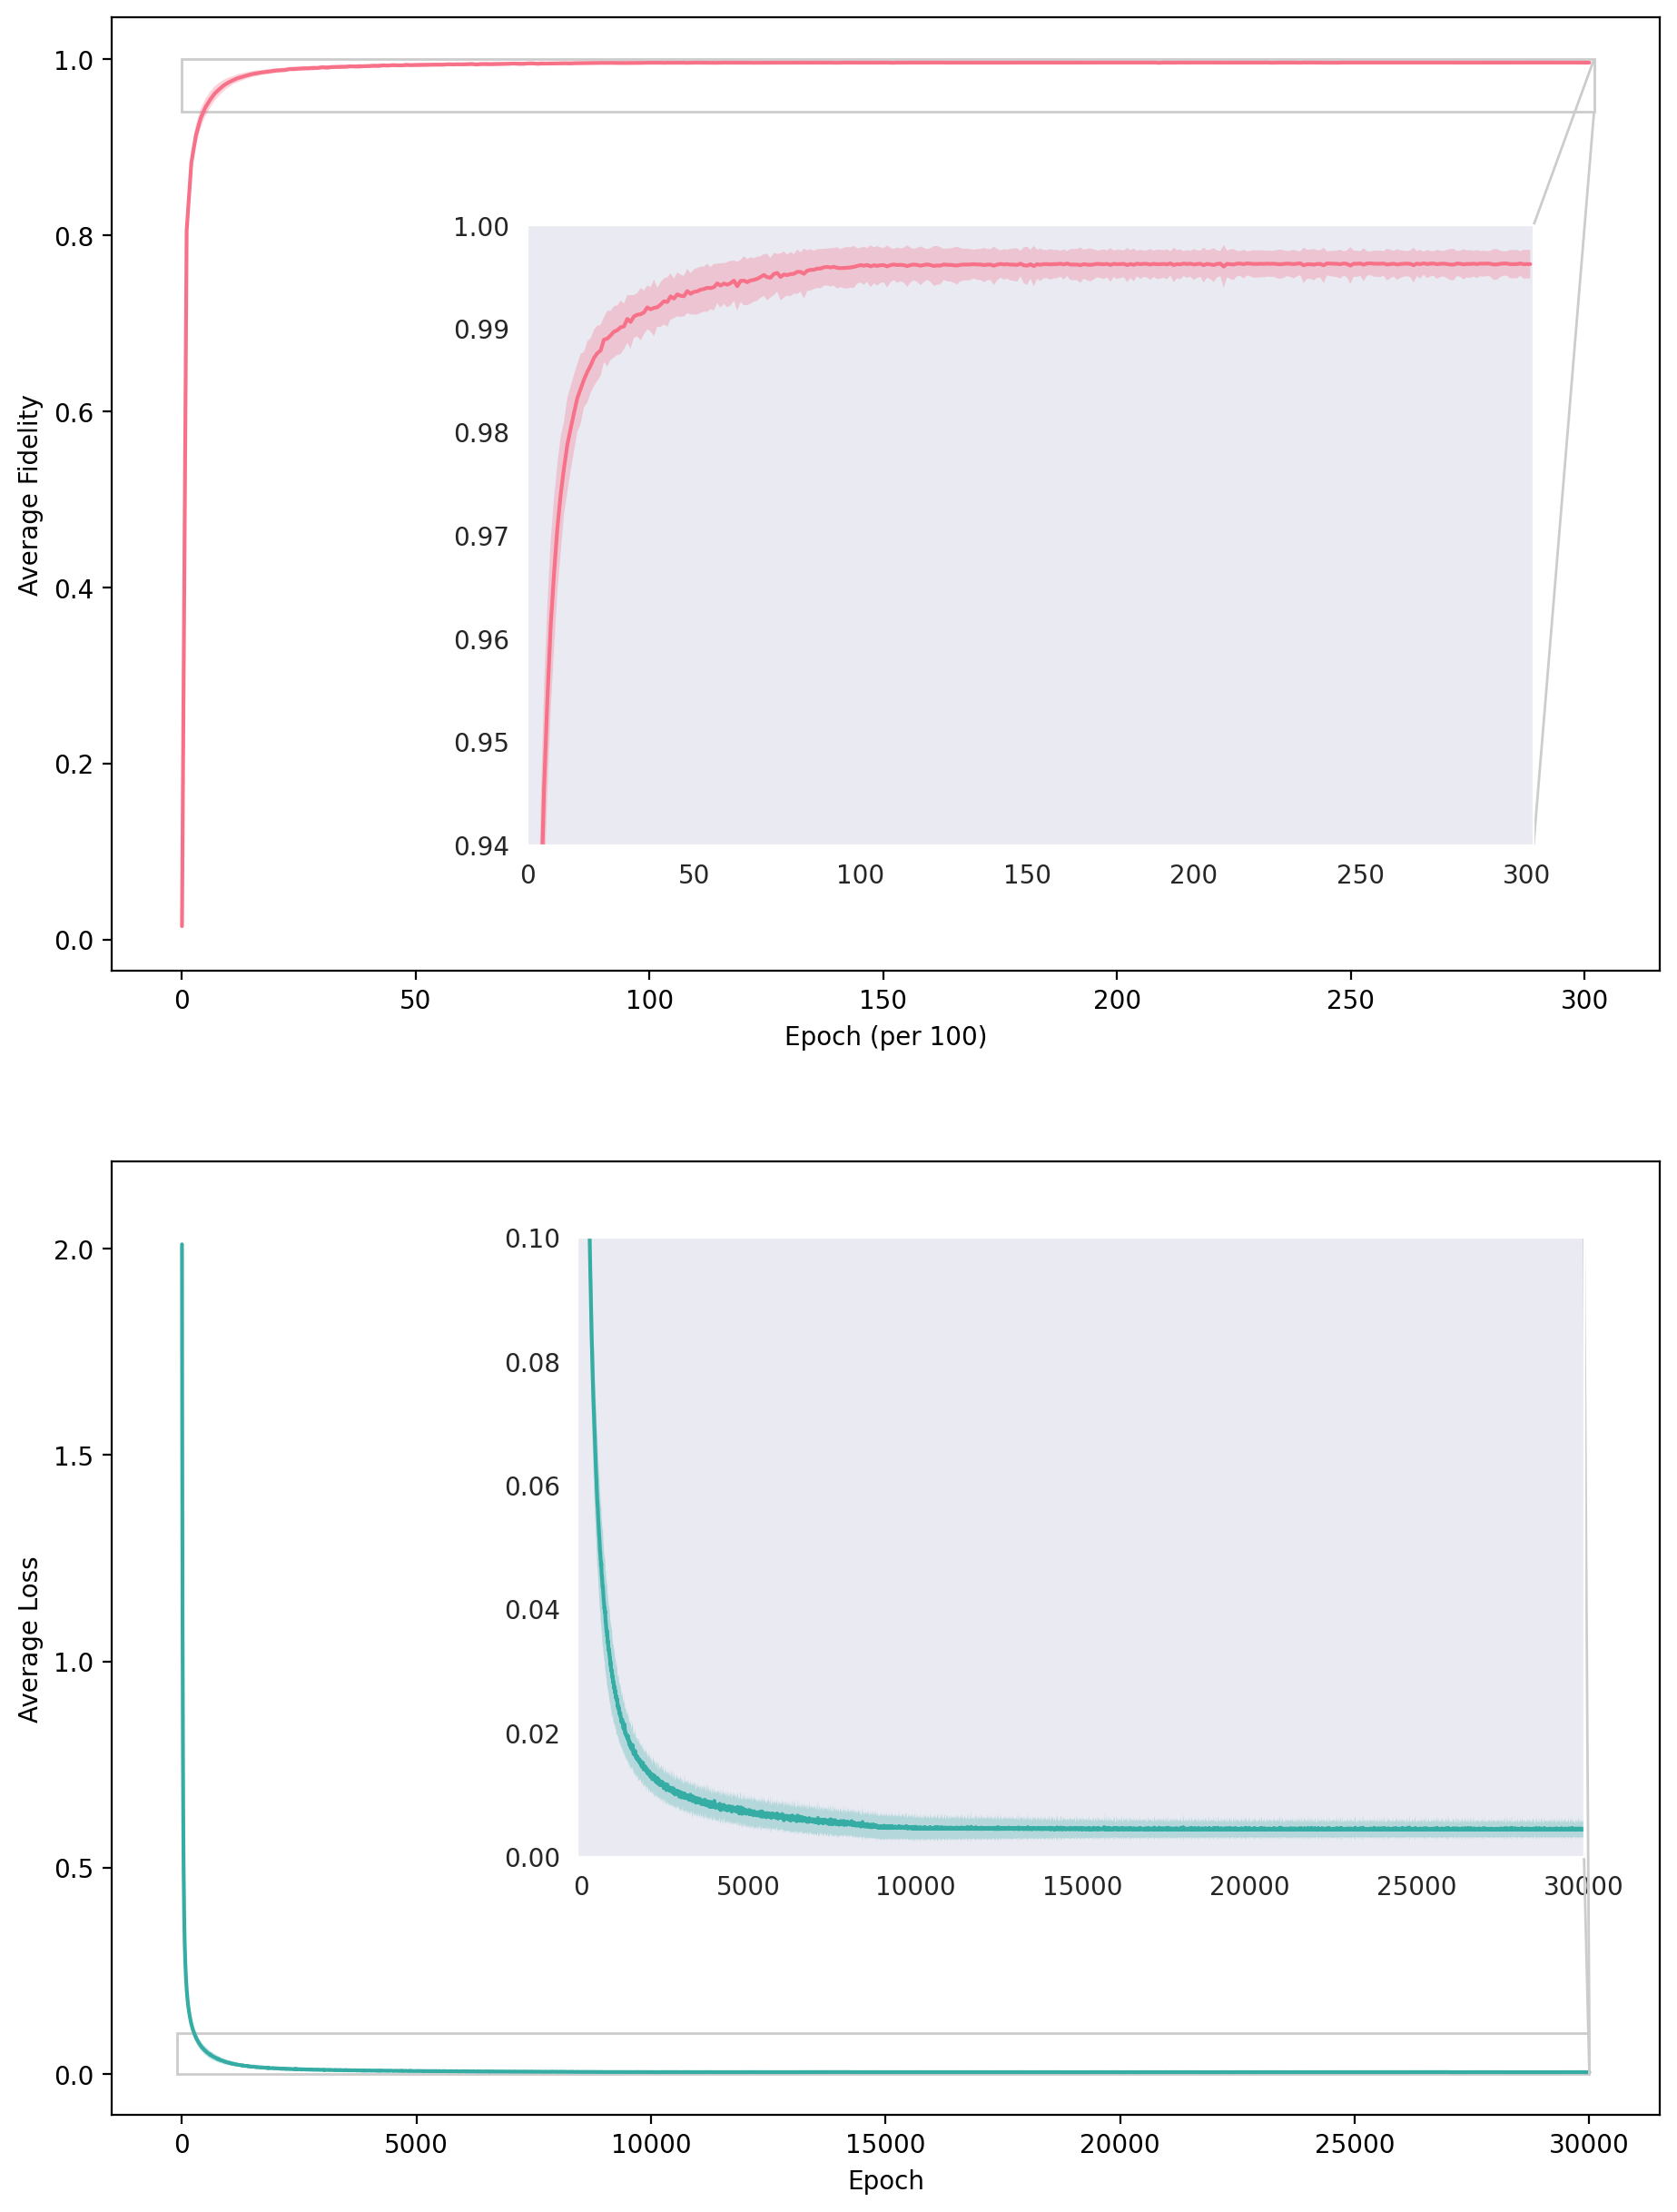

In [174]:
new_fid = []
new_loss = []
fid_len = max([len(arr) for arr in fidelity_all]) # Find the run with the most iterations and retrieve its value
loss_len = max([len(arr) for arr in loss_all])

average_final_fid = np.mean([fidelity_all[i][-1] for i in range(num_agents)]) # Calculate the average of the final average fidelity values for each run

# Pad each average fidelity list with its last value to make it as long as fid_len
for i in range(len(fidelity_all)):
    if len(fidelity_all[i]) != fid_len:
        temp_fid = fidelity_all[i] + [fidelity_all[i][-1] for j in range(len(fidelity_all[i]), fid_len)]
    else:
        temp_fid = fidelity_all[i]
    new_fid.append(temp_fid)

# Pad each average loss value list with its last value to make it as long as loss_len
for i in range(len(loss_all)):
    if len(loss_all[i]) != loss_len:
        temp_loss = loss_all[i] + [loss_all[i][-1] for j in range(len(loss_all[i]), loss_len)]
    else:
        temp_loss = loss_all[i]
    new_loss.append(temp_loss)

new_fid = np.array(new_fid)
new_loss = np.array(new_loss)

# Used for representation of fluctuations in learning curves
fid_means = np.mean(new_fid, axis=0)
fid_stds = np.std(new_fid, axis=0)
loss_means = np.mean(new_loss, axis=0)
loss_stds = np.std(new_loss, axis=0)

# Create the average fidelity and loss plots
fig, ax = plt.subplots(2, 1, figsize=(11.0, 15.0), dpi=200)
ax[0].set_ylabel('Average Fidelity')
ax[0].set_xlabel('Epoch (per 100)')
ax[1].set_ylabel('Average Loss')
ax[1].set_xlabel('Epoch')
colors = sns.color_palette("husl", 2)
plot_cut_fid = len(fid_means)-0
plot_cut1_fid = 0
plot_cut_loss = len(loss_means)-0
plot_cut1_loss = 0

with sns.axes_style("darkgrid"):
    fid_means_cut = fid_means[plot_cut1_fid:plot_cut_fid]
    fid_stds_cut = fid_stds[plot_cut1_fid:plot_cut_fid]
    x_fid = np.arange(len(fid_means_cut))
    loss_means_cut = loss_means[plot_cut1_loss:plot_cut_loss]
    loss_stds_cut = loss_stds[plot_cut1_loss:plot_cut_loss]
    x_loss = np.arange(len(loss_means_cut))

    # Define the region to magnify
    xf1, xf2, yf1, yf2 = 0, fid_len, 0.94, 1.0
    xl1, xl2, yl1, yl2 = -100, loss_len, -0.0001, 0.1
    
    # Create inset for the magnified region
    ax_inset = inset_axes(ax[0], width="65%", height="65%", loc="lower right", borderpad=5)
    ax_inset.plot(x_fid, fid_means_cut, c=colors[0])
    ax_inset.fill_between(x_fid, y1=fid_means_cut-fid_stds_cut, y2=fid_means_cut+fid_stds_cut ,alpha=0.3, facecolor=colors[0])
    ax_inset.set_xlim(xf1, xf2)
    ax_inset.set_ylim(yf1, yf2)
    ax_inset.grid(False)
    ax_inset1 = inset_axes(ax[1], width="65%", height="65%", loc="upper right", borderpad=3)
    ax_inset1.plot(x_loss, loss_means_cut, c=colors[1]) 
    ax_inset1.fill_between(x_loss, y1=loss_means_cut-loss_stds_cut, y2=loss_means_cut+loss_stds_cut ,alpha=0.3, facecolor=colors[1])
    ax_inset1.set_xlim(xl1, xl2)
    ax_inset1.set_ylim(yl1, yl2)
    ax_inset1.grid(False)
    
    # Mark the inset regions on the main plots
    mark_inset(ax[0], ax_inset, loc1=1, loc2=4, fc="none", ec="0.8")
    mark_inset(ax[1], ax_inset1, loc1=1, loc2=4, fc="none", ec="0.8")
    ax[0].plot(x_fid, fid_means_cut, c=colors[0]) 
    ax[0].fill_between(x_fid, y1=fid_means_cut-fid_stds_cut, y2=fid_means_cut+fid_stds_cut ,alpha=0.3, facecolor=colors[0])
    ax[1].plot(x_loss, loss_means_cut, c=colors[1]) 
    ax[1].fill_between(x_loss, y1=loss_means_cut-loss_stds_cut, y2=loss_means_cut+loss_stds_cut ,alpha=0.3, facecolor=colors[1])
    ax[1].set_ylim(-0.1, max(loss_means_cut)+0.2)
    
plt.show()

In [160]:
print("Average Final Fidelity: {a0}".format(a0=average_final_fid), "\n")
new_params = [list(i.clone().detach().numpy()) for i in operator.params]
new_nrot1 = [list(i.clone().detach().numpy()) for i in operator.nrot1]
new_nrot2 = [list(i.clone().detach().numpy()) for i in operator.nrot2]
print("Rotation Angles:")
print(new_params, "\n")
print("Rotation Direction Angles 1:")
print(new_nrot1, "\n")
print("Rotation Direction Angles 2:")
print(new_nrot2)

Average Final Fidelity: 0.9962370171416873 

Rotation Angles:
[[17.625178082402584, 14.978584575099104, 9.47160530014444, 3.581738929467184, 14.177790216978385, 16.173624089449373], [4.686332056879022, 11.119540721527727, 3.556744862859661, 30.63998174468352, 19.028123232697865, 28.906554699213], [5.064124245578537, 20.157734119746625, 3.582459974414078, 16.506349900206516, 29.618643711178834, 10.844394800892076], [18.84810478240283, 19.158590615565792, 4.52867872200209, 4.195495573825723, 5.141169199533943, 29.987460256092223], [12.575148332270333, 21.666171531634525, 28.43839324293183, 11.034707080922255, 2.8577752352484644, 15.86691407273381], [23.563671876894983, 4.79139805259849, 8.4760438001603, 16.110484799718307, 30.047712070810476, 7.562868543296012], [29.88413938311405, 4.404889228092673, 9.743612096876966, 4.926623703710381, 9.512646828067712, 27.832700834525937], [6.698183187798366, 3.294269647499428, 30.65827611981155, 10.872784497276518, 7.132009742594518, 16.620015446409

In [175]:
print(loss_means[-1], fid_means[-1])
print(loss_stds[-1], fid_stds[-1])

0.004436040817453498 0.9962370171416872
0.0013871621555061942 0.001376444007721659
